In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
from two_tailed_z_test import sig_test

Exploratory hypothesis testing of the influence of a new landing page vs old landing page on user click through rate based on data from Etsy. Assumptions are that sample size is sufficiently large and that all samples are identical and independently distributed (iid)

*Experimental data collected on one day of the week

In [36]:
df = pd.read_csv('experiment.csv')
country = pd.read_csv('country.csv')

In [37]:
df.head()

,user_id,ts,ab,landing_page,converted
0,4040615247,1.356998e+09,treatment,new_page,0
1,4365389205,1.356998e+09,treatment,new_page,0
2,4256174578,1.356998e+09,treatment,new_page,0
3,8122359922,1.356998e+09,control,old_page,0
4,6077269891,1.356998e+09,control,old_page,0


In [38]:
country.head()

,user_id,country
0,9160993935,UK
1,5879439034,UK
2,8915383273,UK
3,2917824565,US
4,3980216975,UK


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191148 entries, 0 to 191147
Data columns (total 5 columns):
user_id         191148 non-null int64
ts              191148 non-null float64
ab              191148 non-null object
landing_page    191148 non-null object
converted       191148 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 7.3+ MB


In [40]:
country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185076 entries, 0 to 185075
Data columns (total 2 columns):
user_id    185076 non-null int64
country    185076 non-null object
dtypes: int64(1), object(1)
memory usage: 2.8+ MB


In [42]:
#remove duplicates
df.drop_duplicates('user_id', keep='last', inplace=True)

#remove confilcting inputs (ie treatment ==  control)
mask_treatment_newpage = (df['ab'] == 'treatment') & (df['landing_page'] == 'new_page')
mask_treatment_oldpage = (df['ab'] == 'treament') & (df['landing_page'] == 'old_page')
mask_control_newpage = (df['ab'] == 'control') & (df['landing_page'] == 'new_page')
mask_control_oldpage = (df['ab'] == 'control') & (df['landing_page'] == 'old_page')
masks = [mask_treatment_newpage, mask_treatment_oldpage, mask_control_newpage, mask_control_oldpage]

#check for conflicts by length discrepancy
df_length = [len(df[m]) for m in masks]

#new dataframe excluding discrepancies and duplicates
df = df[~mask_treatment_oldpage]

In [49]:
#dataframe with only control group
old = df[df['ab'] == 'control']

#baseline click-through rate
old_numerator = old[old['converted'] == 1]
old_denominator = old['ab'].count()
ctr_old = old_numerator['converted'].size / old_denominator
ctr_old


0.09964322681524874

In [70]:
#dataframe with only treatment group
new = df[df['ab'] == 'treatment']

#treated click-through rate
new_numerator = new[new['converted'] == 1]
new_denominator = new['ab'].count()
ctr_new = new_numerator['converted'].size / new_denominator
ctr_new

0.10492393328729571

In [71]:
#number of observations from control group
nobs_old = old_denominator

In [72]:
#number of observations from treatment group
nobs_new = new_denominator

In [73]:
nobs_old, nobs_new

(90814, 95574)

In [74]:
sig_test(ctr_old, ctr_new, nobs_old, nobs_new)

z-score: 3.759499215723849, p-value: 0.00017025381130486572, reject null: True


(3.759499215723849, 0.00017025381130486572, True)

Based on the calculated p-value of 0.00017, we can reject the null hypothesis that the lift does not cross the threshold of 1%

However, we should be hesistant to accept that this test was significant because this data is only represeantative of one day of the week. User behavior may differ on other days or weekends, and there may be other confounding factors affecting conversion rate. To confirm, we should collect similar data for each day as comparison.



It is important to note that we should not interrupt an analysis in real-time if we notice our p-values reaching significance. Structuring our data as a time series analysis will illustrate why.

z-score: 1.3390249517174873, p-value: 0.09028127505645223, reject null: False
z-score: 1.564116082307394, p-value: 0.05889515490572772, reject null: False
z-score: 1.9023315748108924, p-value: 0.028563910141609306, reject null: True
z-score: 2.06941511073995, p-value: 0.019253574867581946, reject null: True
z-score: 2.070817137955615, p-value: 0.019187944019460557, reject null: True
z-score: 2.404300094240038, p-value: 0.008101732834957853, reject null: True
z-score: 1.9759691734751146, p-value: 0.024079134342919972, reject null: True
z-score: 2.2117975905188647, p-value: 0.013490326841059663, reject null: True
z-score: 2.4122798373461527, p-value: 0.0079265543409891, reject null: True
z-score: 1.841684210207923, p-value: 0.032760677581939124, reject null: True
z-score: 1.8670946436228693, p-value: 0.03094418614992611, reject null: True
z-score: 2.180207004401277, p-value: 0.014621060321350243, reject null: True
z-score: 2.126944050523457, p-value: 0.016712366098007858, reject null: Tr

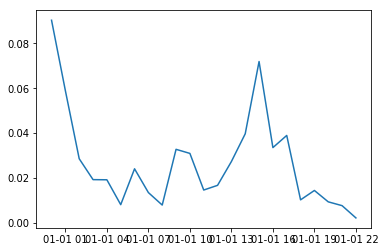

In [84]:
def time_series(ctr_old, ctr_new, nobs_old, nobs_new):
    
    #create time series
    df['ts'] = pd.to_datetime( df['ts'], unit='s' )
    e = len(df['ts']) -1
    hours = pd.date_range(start=df['ts'][0],   periods = 25, freq = 'H')

    
    result = []
    for i in range(1, len(hours)-1):

        past = df[df['ab'] == 'control']

        past = past.loc[ df['ts'] <= '2013-01-01 0{}:00:00'.format(i)]

        ctr_num = past[past['converted'] == 1]
        denom_ctrl = past['ab'].count()
        ctr_old = ctr_num['converted'].size / denom_ctrl
        nobs_old = denom_ctrl


        new = df[df['ab'] == 'treatment']

        new = new.loc[ df['ts'] <= '2013-01-01 0{}:00:00'.format(i)]

        ctr_num = new[new['converted'] == 1]
        denom_treat = new['ab'].count()
        ctr_new = ctr_num['converted'].size / denom_treat
        nobs_new = denom_treat

        z = sig_test(ctr_old, ctr_new, nobs_old, nobs_new, effect_size=.001, two_tailed=False)
        result.append(z[1])
    return plt.plot(hours[0:-2], result)

print(time_series(ctr_old, ctr_new, nobs_old, nobs_new))

Althought the test seems to reach significance around 15 hours it is important to allow the analysis to come to completion and settle towards the mean. As we see in this time series data, p-values for each time slice represents some chance of incorrectly rejecting our null hypothesis. As our real-time p-value fluctuates, the collection of these values bring us closer to a true representation of the data. If prematurely cut short there are not enough data points to reject or accept our null hypothesis with confidence.